# Description

DCGAN is the first published approach that uses CNN instead of MLPs for either the discrimnator and the Generator.

paper: [DCGAN paper](https://arxiv.org/pdf/1511.06434)

in the paper they gave some architecture guidelines:
- Replace any pooling layers with strided conv (discriminator) and fractional-strided conv (generator)
- Use BatchNorm in both generator and discriminator
- Use ReLU activation in generator in each layer execept for the output (which uses Tanh)
- Use LeakyReLU activiation in the discriminator for all layers


In [1]:
import torch
import torch.nn as nn

# Creation of the Discriminator and Generator

In [6]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, channels):
    super(Discriminator, self).__init__()


    self.disc = nn.Sequential(
        # Input: N x channels x 64 x 64
        nn.Conv2d(
            channels_img,
            channels,
            kernel_size=4, # on the paper thay say 5x5 but in their code appears a 4x4 kernel size
            stride=2,
            padding=1
        ), # 32 x 32
        nn.LeakyReLU(0.2),
        self._block(channels, channels*2, 4, 2, 1), # 16 x 16
        self._block(channels*2, channels*4, 4, 2, 1), # 8 x 8
        self._block(channels*4, channels*8, 4, 2, 1), # 4 x 4
        nn.Conv2d(
            channels*8,
            1,
            kernel_size=4,
            stride=2,
            padding=0
          ), # 1 x 1
        nn.Sigmoid(),
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
      return nn.Sequential(
          nn.Conv2d(
              in_channels,
              out_channels,
              kernel_size,
              stride,
              padding,
              bias=False # becaude i'm using the BatchNorm
          ),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(0.2), # using the parameter of the paper
      )

  def forward(self, x):
    return self.disc(x)

In [7]:
class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, channels):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        # Input: N (batchsize) x z_dim x 1 x 1
        self._block(z_dim, channels*16, 4, 1, 0), # N x channels*16 x 4 x 4
        self._block(channels*16, channels*8, 4, 2, 1), # 8 x 8
        self._block(channels*8, channels*4, 4, 2, 1), # 16 x 16
        self._block(channels*4, channels*2, 4, 2, 1), # 32 x 32
        nn.ConvTranspose2d(
            channels*2,
            channels_img,
            kernel_size=4,
            stride=2,
            padding=1
          ), # 64 x 64
        nn.Tanh(), # [-1, 1]
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
      return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            # bias=False
          ),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
      )

  def forward(self, x):
    return self.gen(x)

## Weights initialization

In [12]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [13]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))

  discriminator = Discriminator(in_channels, 8)
  initialize_weights(discriminator)
  assert discriminator(x).shape == (N, 1, 1, 1) # see if the discriminator outputs correctly the tensor shape

  generator = Generator(z_dim, in_channels, 8)
  initialize_weights(generator)
  z = torch.randn((N, z_dim, 1, 1))
  assert generator(z).shape == (N, in_channels, H, W) # see if the generator outputs correctly the tensor shape

  print("Success :)")

In [14]:
test()

Success :)


# Training setup

In [15]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 2e-4 # from the paper
batch_size = 128
img_size = 64
channels_img = 1
z_dim = 100
epochs = 50
features_disc = 64
features_gen = 64

In [12]:
transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
       transforms.ToTensor(),
       transforms.Normalize(
           # this will help to be able to use other datasets
           [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]
       ),
    ]
)

In [17]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)

100.0%
100.0%
100.0%
100.0%


## Models initialization

In [18]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [19]:
gen = Generator(z_dim, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)

In [20]:
initialize_weights(gen)
initialize_weights(disc)

In [21]:
opt_gen = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [22]:
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")
step = 0

Epoch [0/5] Batch 0/469 Loss D: 0.6878, Loss G: 0.7741


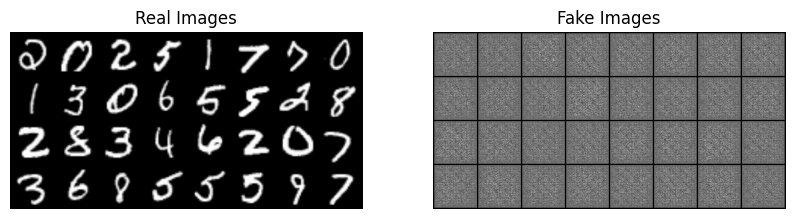

Epoch [1/5] Batch 0/469 Loss D: 0.5546, Loss G: 1.2925


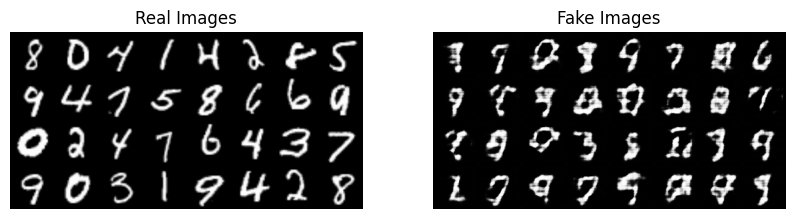

Epoch [2/5] Batch 0/469 Loss D: 0.5535, Loss G: 0.8019


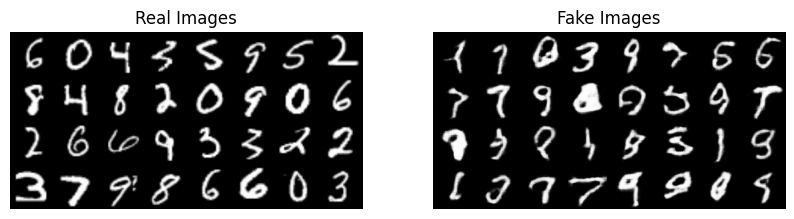

Epoch [3/5] Batch 0/469 Loss D: 0.6216, Loss G: 1.0389


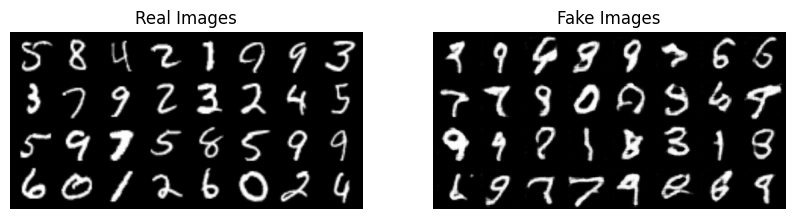

Epoch [4/5] Batch 0/469 Loss D: 0.3330, Loss G: 3.2763


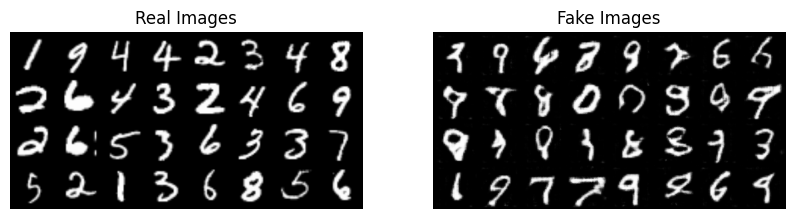

In [23]:
gen.train()
disc.train()

for epoch in range(epochs):
  for batch_idx, (real, _ ) in enumerate(loader): # the '_' goes because i don't need the labels
    real = real.to(device)
    noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
    fake = gen(noise)

    # discriminator training
    disc_real = disc(real).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(gen(noise)).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_disc = (loss_disc_real + loss_disc_fake) / 2
    disc.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_disc.step()

    # generator training
    output = disc(gen(noise)).reshape(-1)
    loss_gen = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if batch_idx == 0:
        print(
            f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(loader)} "
            f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
        )

        with torch.no_grad():
            fake = gen(fixed_noise)
            # creating a grid of images
            img_grid_real = torchvision.utils.make_grid(
                real[:32], normalize=True
            )
            img_grid_fake = torchvision.utils.make_grid(
                fake[:32], normalize=True
            )

            # plot the images with matplotlib
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(img_grid_real.permute(1, 2, 0).cpu().numpy())
            ax[0].set_title("Real Images")
            ax[0].axis("off")

            ax[1].imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
            ax[1].set_title("Fake Images")
            ax[1].axis("off")

            plt.show()


            # adding the images to the TensorBoard logs
            """ writer_fake.add_image(
              "Mnist Fake Images", img_grid_fake, global_step=step
            )
            writer_real.add_image(
                "Mnist Real Images", img_grid_real, global_step=step
            ) """

        step += 1

In [24]:
# save the models
torch.save(gen.state_dict(), "./models/gen.pth")
torch.save(disc.state_dict(), "./models/disc.pth")

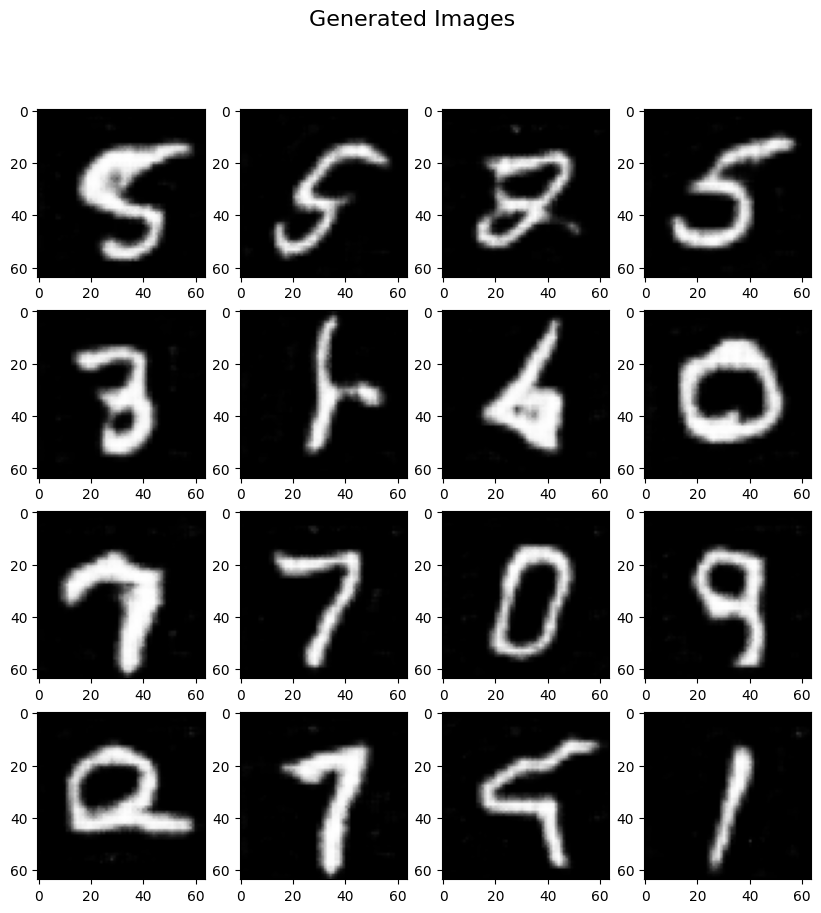

In [30]:
import torch
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt

gen.eval()
noise = torch.randn((batch_size, 100, 1, 1)).to(device)
with torch.no_grad():
    fake = gen(noise)

# plot image
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Generated Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(fake[i].cpu().numpy().squeeze(), cmap='gray')


# First results

With just 5 epochs this architecture achieves better results than the MLPGAN, maybe is because the convolutional layers that allows the model to capture more detailes and spatial context of the images, now, i will test this with the lego dataset.

# Download the lego dataset

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")

print("Path to dataset files:", path)
# Move dataset to a more accessible location

# mv /root/.cache/kagglehub/datasets/joosthazelzet/ <dest_path>

/home/lexo/miniconda3/envs/ml/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.00G/1.00G [01:44<00:00, 10.3MB/s]

Extracting files...


Path to dataset files: /home/lexo/.cache/kagglehub/datasets/joosthazelzet/lego-brick-images/versions/4


In [16]:
!mv /home/lexo/.cache/kagglehub/datasets/joosthazelzet/lego-brick-images/versions/4 /home/lexo/dev/models/GAN/DCGAN/data/

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

class LegoDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = []
        for filename in os.listdir(root_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                self.dataset.append((filename,))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataset[idx][0])
        image = Image.open(img_name).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        # Return as dictionary
        sample = {'image': image}
        return image # i return the tensor directly for simplicity (instead of the dict)

    def __plot__(self):
        fig = plt.figure(figsize=(8, 8))
        for i, sample in enumerate(self):
            print(i, sample['image'].shape)

            ax = plt.subplot(1, 4, i + 1)
            ax.imshow(sample['image'].permute(1, 2, 0).numpy())
            ax.set_title('Sample #{}'.format(i))
            ax.axis('off')

            if i == 3:
                plt.show()
                break


# lego_dataset = LegoDataset(root_dir=PATH, transform=transform)
# lego_dataset.__plot__()




# Initial configurations 
(just copy paste from above except for the dataset class initialization)

In [16]:
transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
       transforms.ToTensor(),
       transforms.Normalize(
           # this will help to be able to use other datasets
           [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]
       ),
    ]
)

lego_dataset = LegoDataset(root_dir="./data/dataset/", transform=transforms)

loader = DataLoader(lego_dataset, batch_size=batch_size, shuffle=True)

gen = Generator(z_dim, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)

initialize_weights(gen)
initialize_weights(disc)

opt_gen = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

# Train methods


In [22]:
gen.train()
disc.train()

for epoch in range(epochs):
  for batch_idx, real in enumerate(loader):
    real = real.to(device)
    noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
    fake = gen(noise)

    # discriminator training
    disc_real = disc(real).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(gen(noise)).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_disc = (loss_disc_real + loss_disc_fake) / 2
    disc.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_disc.step()

    # generator training
    output = disc(gen(noise)).reshape(-1)
    loss_gen = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if batch_idx == 0:
        print(
            f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(loader)} "
            f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
        )

        with torch.no_grad():
            fake = gen(fixed_noise)
            # creating a grid of images
            img_grid_real = torchvision.utils.make_grid(
                real[:32], normalize=True
            )
            img_grid_fake = torchvision.utils.make_grid(
                fake[:32], normalize=True
            )

            # plot the images with matplotlib (in this case i wont plot the images because i'm doing 50 epochs)
            """ fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(img_grid_real.permute(1, 2, 0).cpu().numpy())
            ax[0].set_title("Real Images")
            ax[0].axis("off")

            ax[1].imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
            ax[1].set_title("Fake Images")
            ax[1].axis("off")

            plt.show()
 """

            # adding the images to the TensorBoard logs
            writer_fake.add_image(
              "Mnist Fake Images", img_grid_fake, global_step=step
            )
            writer_real.add_image(
                "Mnist Real Images", img_grid_real, global_step=step
            )

        step += 1

Epoch [0/50] Batch 0/313 Loss D: 0.0117, Loss G: 4.3164
Epoch [1/50] Batch 0/313 Loss D: 0.6070, Loss G: 0.7648
Epoch [2/50] Batch 0/313 Loss D: 0.6711, Loss G: 0.7960
Epoch [3/50] Batch 0/313 Loss D: 0.6894, Loss G: 0.7212
Epoch [4/50] Batch 0/313 Loss D: 0.6902, Loss G: 0.6643
Epoch [5/50] Batch 0/313 Loss D: 0.6821, Loss G: 0.8320
Epoch [6/50] Batch 0/313 Loss D: 0.6654, Loss G: 0.7377
Epoch [7/50] Batch 0/313 Loss D: 0.7250, Loss G: 0.7616
Epoch [8/50] Batch 0/313 Loss D: 0.6636, Loss G: 0.8902
Epoch [9/50] Batch 0/313 Loss D: 0.6478, Loss G: 0.8809
Epoch [10/50] Batch 0/313 Loss D: 0.6548, Loss G: 0.7760
Epoch [11/50] Batch 0/313 Loss D: 0.6379, Loss G: 1.0794
Epoch [12/50] Batch 0/313 Loss D: 0.5978, Loss G: 1.0363
Epoch [13/50] Batch 0/313 Loss D: 0.5828, Loss G: 0.8403
Epoch [14/50] Batch 0/313 Loss D: 0.5628, Loss G: 1.3972
Epoch [15/50] Batch 0/313 Loss D: 0.5205, Loss G: 1.0451
Epoch [16/50] Batch 0/313 Loss D: 0.4509, Loss G: 1.8925
Epoch [17/50] Batch 0/313 Loss D: 0.5001,

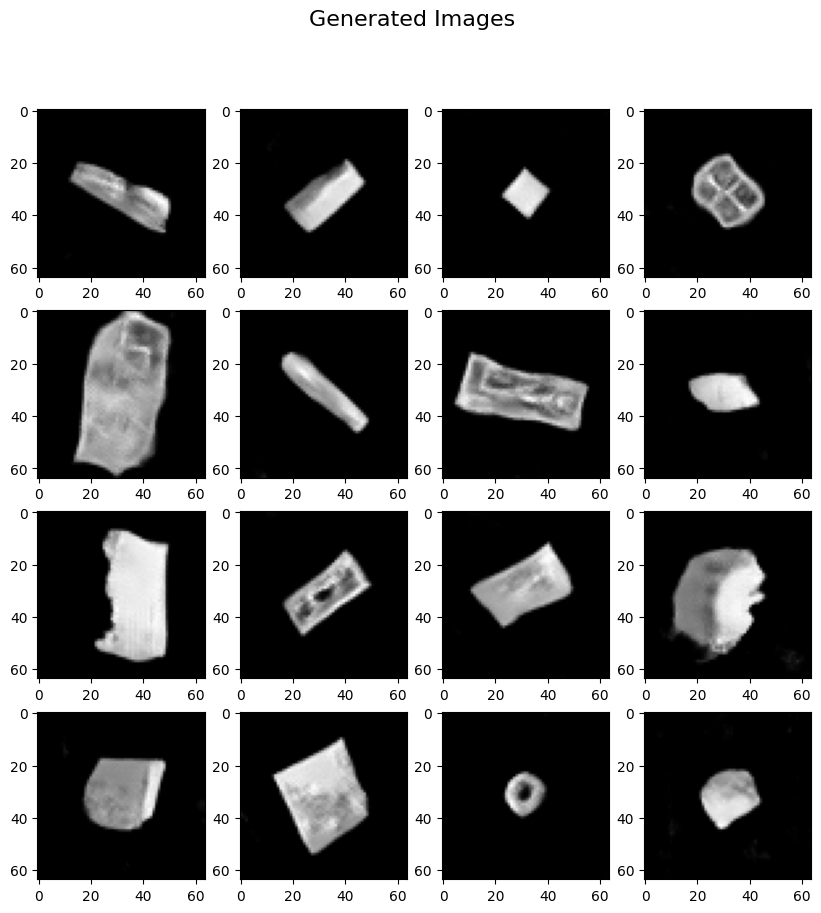

In [23]:
import torch
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt

gen.eval()
noise = torch.randn((batch_size, 100, 1, 1)).to(device)
with torch.no_grad():
    fake = gen(noise)

# plot image
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Generated Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(fake[i].cpu().numpy().squeeze(), cmap='gray')


# Conclusion

This are awesome reults compared to the "Vainilla GAN" or MLPGAN, in the case of the MNIST dataset it generated in just 5 epochs better results than 50 epochs of the MLPGAN, also,  related to the lego images generation still needs more training (i just have to leave it more epochs) but it successfully captured some important features of the lego blocks.  